<a href="https://colab.research.google.com/github/i-m-alamin/Custom-CNN-classification-method-that-are-based-on-watershed-segmentation/blob/main/Proposed_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
from concurrent import futures
import threading
from sklearn.model_selection import train_test_split
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

In [ ]:
#Data Loading
# set root as images folder path of dataset
root ="CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

# read dataset
base_dir = os.path.join(root)
cyst_dir = os.path.join(base_dir,'Cyst')
normal_dir = os.path.join(base_dir,'Normal')
stone_dir = os.path.join(base_dir,'Stone')
tumor_dir = os.path.join(base_dir,'Tumor')

cyst_files = glob.glob(cyst_dir+'/*.jpg')
normal_files = glob.glob(normal_dir+'/*.jpg')
stone_files = glob.glob(stone_dir+'/*.jpg')
tumor_files = glob.glob(tumor_dir+'/*.jpg')

len(cyst_files), len(normal_files),len(stone_files), len(tumor_files) 

(3709, 5077, 1377, 2283)

In [ ]:
#Check top 5 rows of data
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': cyst_files + normal_files + stone_files + tumor_files,
    'label': ['Cyst'] * len(cyst_files) + ['Normal'] * len(normal_files) + ['Stone']* len(stone_files) + ['Tumor'] * len(tumor_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-K...,Cyst
1,CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-K...,Cyst
2,CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-K...,Stone
3,CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-K...,Cyst
4,CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-K...,Cyst


In [ ]:
# Data Splitting
# Partition dataset into training(60),testing(30),validation(10) 
train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(7840,) (872,) (3734,)
Train: Counter({'Normal': 3181, 'Cyst': 2342, 'Tumor': 1447, 'Stone': 870}) 
Val: Counter({'Normal': 368, 'Cyst': 256, 'Tumor': 143, 'Stone': 105}) 
Test: Counter({'Normal': 1528, 'Cyst': 1111, 'Tumor': 693, 'Stone': 402})


In [ ]:
# Check image Dimensions
def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_13: working on img num: 5000
ThreadPoolExecutor-0_9: working on img num: 7839
Min Dimensions: [451 512   3]
Avg Dimensions: [575.2184949  636.05306122   3.        ]
Median Dimensions: [512. 512.   3.]
Max Dimensions: [1110 1371    3]


In [ ]:
#Watershed segmentation
def segmentation(image):
  gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  #Performing Otsu's Binarization : This means that if the value of the pixel exceeds the threshold, it would be considered as 1. Else, 0
  ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  #print("Threshold limit: " + str(ret))

  #Specifying the Background and Foreground after Noise Removal
  # noise removal
  kernel = np.ones((3, 3), np.uint8)
  opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

  # sure background area
  sure_bg = cv2.dilate(opening, kernel, iterations = 3)

  #Performing Distance Transfrom : In distance transfrom, the gray level intensities of the points inside the foreground
  # are changed to distance their respective distances from the closest 0 value
  
  # sure foreground area
  dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
  ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

  # Finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)

  # Connected Components
  ret, markers = cv2.connectedComponents(sure_fg)
  markers = markers + 1
  markers[unknown==255] = 0

  #Applying Watershed Segmentation
  markers = cv2.watershed(image, markers)
  image[markers == -1] = [0, 255,0]
  return image

In [ ]:
# Image Resizing and Watershed Segmentation
IMG_DIMS = (165,165)
INPUT_SHAPE = (165,165, 3)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    #img = cv2.bilateralFilter(img, 15, 75, 75) 
    img = cv2.resize(img, dsize=IMG_DIMS, interpolation=cv2.INTER_CUBIC)
    img = segmentation(img)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_10: working on img num: 5000
ThreadPoolExecutor-1_3: working on img num: 7839

Loading Validation Images:
ThreadPoolExecutor-1_10: working on img num: 0
ThreadPoolExecutor-1_13: working on img num: 871

Loading Test Images:
ThreadPoolExecutor-1_5: working on img num: 0
ThreadPoolExecutor-1_11: working on img num: 3733


((7840, 165, 165, 3), (872, 165, 165, 3), (3734, 165, 165, 3))

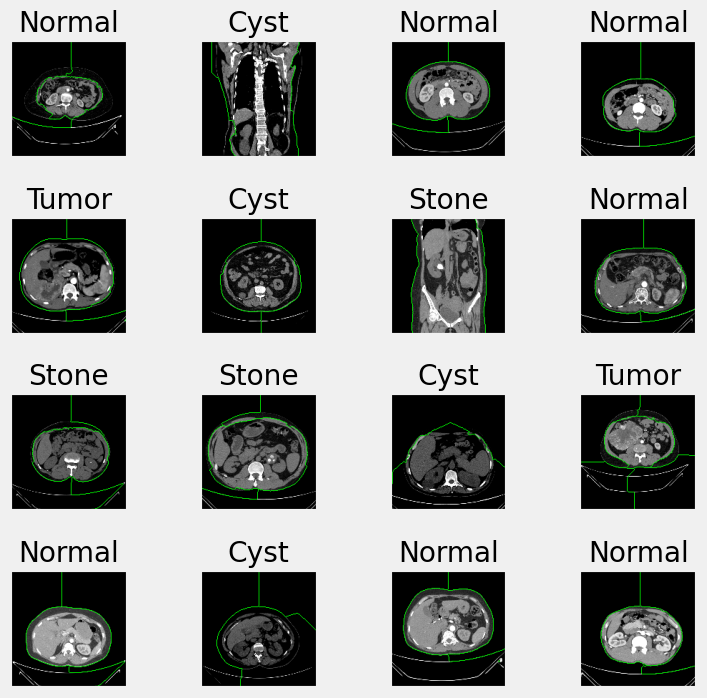

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [ ]:
import tensorflow as tf
# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

#tf.random.set_random_seed(42)
tf.random.set_seed(42)
tf.__version__

'2.11.0'

In [ ]:
# Normalization of data 
train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.
test_imgs_scaled = test_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_t = le.transform(train_labels)
val_labels_t = le.transform(val_labels)
test_labels_t = le.transform(test_labels)

train_labels_enc = tf.keras.utils.to_categorical(train_labels_t, 4)
val_labels_enc = tf.keras.utils.to_categorical(val_labels_t, 4)
test_labels_enc = tf.keras.utils.to_categorical(test_labels_t, 4)


# change version of tensorflow
#%tensorflow_version 2.x
# Cyst = 0 ,  Normal =1  , Stone =2 , Tumor = 3

print(train_labels[:6], train_labels_t[:6])

['Normal' 'Normal' 'Tumor' 'Cyst' 'Cyst' 'Tumor'] [1 1 3 0 0 3]


Labels: ['Normal', 'Normal', 'Normal', 'Normal', 'Normal']


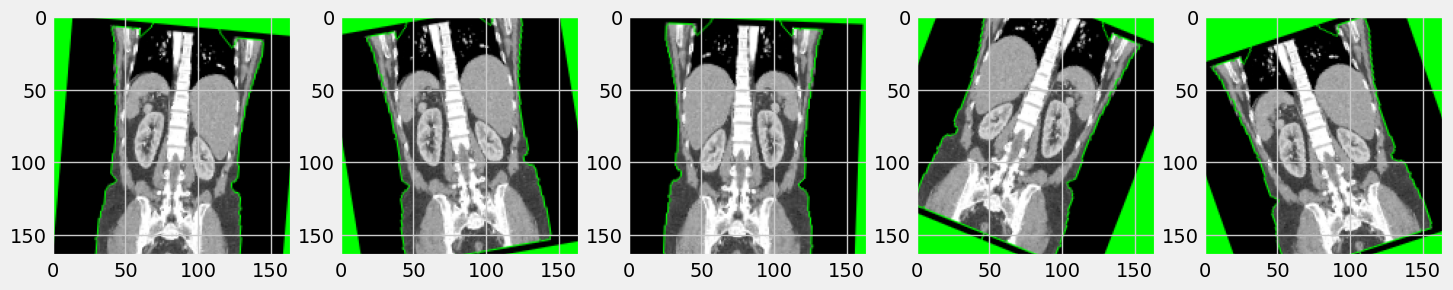

In [ ]:
#Applying Data augmentation to images
BATCH_SIZE = 25
NUM_CLASSES = 4
EPOCHS = 25
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# check augmented images
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]

fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

# build image augmentation generators
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(165,165,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
#model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9,centered=False),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 163, 163, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 81, 81, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 79, 79, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

In [ ]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 12
Total trainable layers: 12


In [ ]:
history = model.fit(train_generator,  epochs=EPOCHS, validation_data=val_generator,  verbose=1)

Epoch 1/25
314/314 [==============================] - 94s 299ms/step - loss: 1.0227 - accuracy: 0.5954 - val_loss: 0.7744 - val_accuracy: 0.7041
Epoch 2/25
314/314 [==============================] - 95s 304ms/step - loss: 0.6069 - accuracy: 0.7635 - val_loss: 0.7392 - val_accuracy: 0.7362
Epoch 3/25
314/314 [==============================] - 95s 301ms/step - loss: 0.3835 - accuracy: 0.8562 - val_loss: 0.3392 - val_accuracy: 0.8911
Epoch 4/25
314/314 [==============================] - 95s 302ms/step - loss: 0.2649 - accuracy: 0.9055 - val_loss: 0.3098 - val_accuracy: 0.9071
Epoch 5/25
314/314 [==============================] - 94s 301ms/step - loss: 0.1982 - accuracy: 0.9315 - val_loss: 0.1946 - val_accuracy: 0.9392
Epoch 6/25
314/314 [==============================] - 95s 303ms/step - loss: 0.1650 - accuracy: 0.9435 - val_loss: 0.1508 - val_accuracy: 0.9518
Epoch 7/25
314/314 [==============================] - 95s 301ms/step - loss: 0.1355 - accuracy: 0.9528 - val_loss: 0.1884 - val_ac

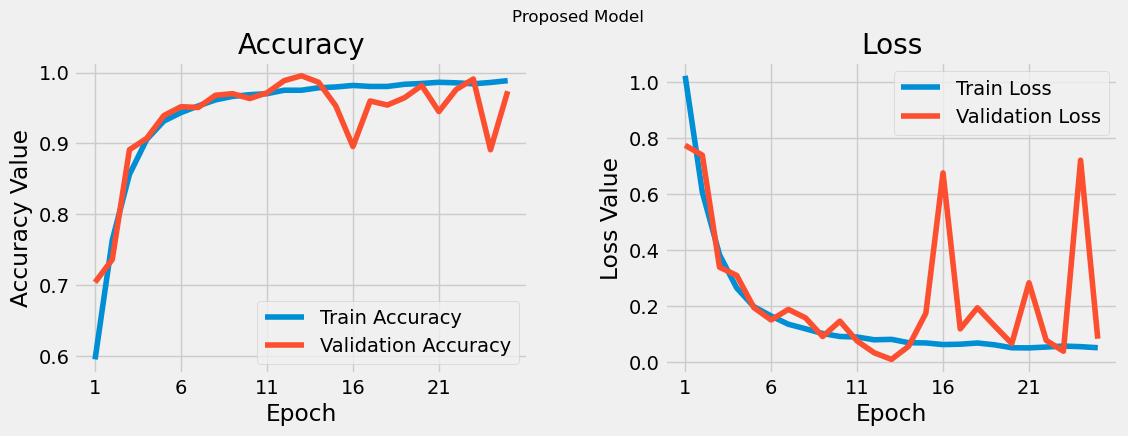

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Proposed Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('KidneyStoneDetector_Proposed_Model.h5')

In [ ]:
#scale test data
test_imgs_scaled.shape, test_labels.shape

((3734, 165, 165, 3), (3734,))

In [ ]:
# Load Saved Deep Learning Models
proposedmodel_frz = tf.keras.models.load_model('KidneyStoneDetector_Proposed_Model.h5')

y_pre_test=proposedmodel_frz.predict(test_imgs_scaled)
y_pre_test=np.argmax(y_pre_test,axis=1)
categories = ['Cyst','Normal', 'Stone','Tumor']

117/117 [==============================] - 9s 75ms/step


In [ ]:
# Model evaluated on training data
score = proposedmodel_frz.evaluate(train_imgs_scaled, train_labels_enc, verbose=0)
print('Training score:', score[0])
print('Training accuracy:', score[1] * 100)

Training score: 0.07081524282693863
Training accuracy: 97.93367385864258


In [ ]:
# Model evaluated on validation data
score = proposedmodel_frz.evaluate(val_imgs_scaled, val_labels_enc, verbose=0)
print('Validation score:', score[0])
print('Validation accuracy:', score[1] * 100)

Validation score: 0.0838184654712677
Validation accuracy: 97.36238718032837


In [ ]:
# Model evaluated on test data
score = proposedmodel_frz.evaluate(test_imgs_scaled, test_labels_enc, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1]  * 100)

Test score: 0.07459122687578201
Test accuracy: 97.7504014968872


In [ ]:
clf_report = pd.DataFrame(classification_report(test_labels_t, y_pre_test,target_names=categories, output_dict=True))
cm = confusion_matrix(test_labels_t, y_pre_test)
print("Test Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(test_labels_t, y_pre_test) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")

Test Result:
Accuracy Score: 97.75%
_______________________________________________
CLASSIFICATION REPORT:
                  Cyst       Normal       Stone       Tumor  accuracy  \
precision     0.943590     0.996726    1.000000    0.981586  0.977504   
recall        0.993699     0.996073    0.823383    1.000000  0.977504   
f1-score      0.967996     0.996399    0.903138    0.990708  0.977504   
support    1111.000000  1528.000000  402.000000  693.000000  0.977504   

             macro avg  weighted avg  
precision     0.980475      0.978459  
recall        0.953289      0.977504  
f1-score      0.964560      0.976852  
support    3734.000000   3734.000000  


In [ ]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    #y_score = clf.decision_function(X_test)
    y_score=proposedmodel_frz.predict(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sn.despine()
    plt.show()

117/117 [==============================] - 9s 73ms/step


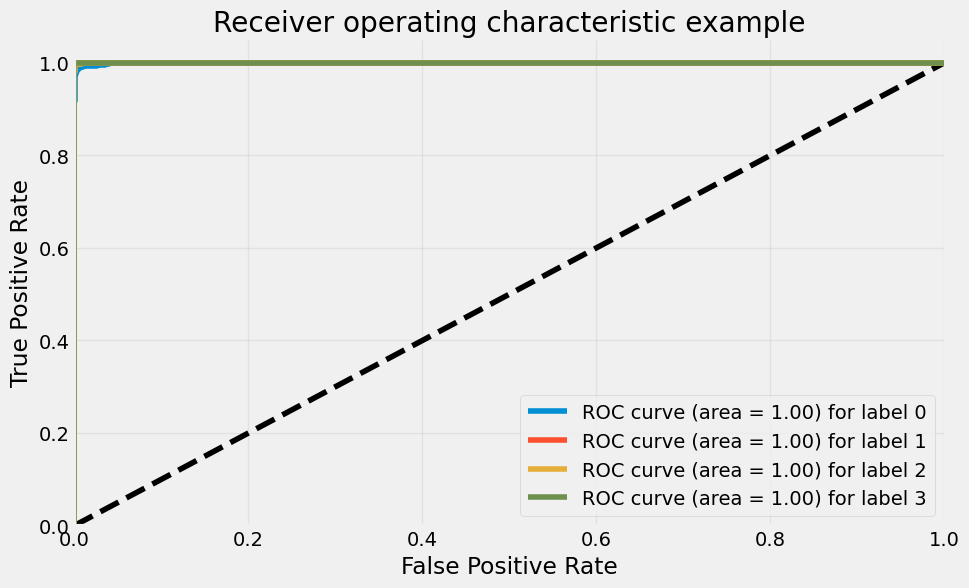

In [ ]:
plot_multiclass_roc(proposedmodel_frz, test_imgs_scaled, test_labels_t, n_classes=4, figsize=(10, 6))

In [ ]:
# ROC AUC scores
y_pred=proposedmodel_frz.predict(test_imgs_scaled)
macro_roc_auc_ovo = roc_auc_score(test_labels_enc, y_pred, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(test_labels_enc, y_pred, multi_class="ovo", average="weighted")

macro_roc_auc_ovr = roc_auc_score(test_labels_enc, y_pred, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(test_labels_enc, y_pred, multi_class="ovr", average="weighted")
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

117/117 [==============================] - 9s 75ms/step
One-vs-One ROC AUC scores:
0.999906 (macro),
0.999891 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.999906 (macro),
0.999891 (weighted by prevalence)


In [ ]:
# Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

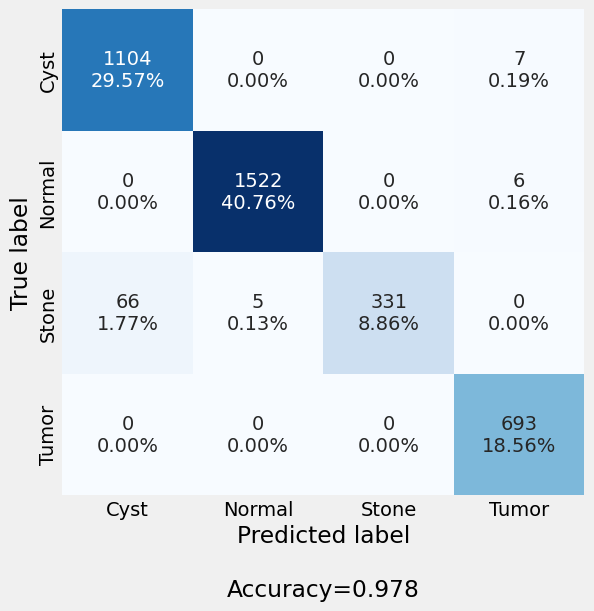

In [ ]:
# Cyst = 0 ,  Normal =1  , Stone =2 , Tumor = 3
categories = ['Cyst','Normal', 'Stone','Tumor']
make_confusion_matrix(cm, categories=categories,figsize=(6,6), cbar=False)
plt.savefig("ConfusionMatrix.png")

<AxesSubplot:>

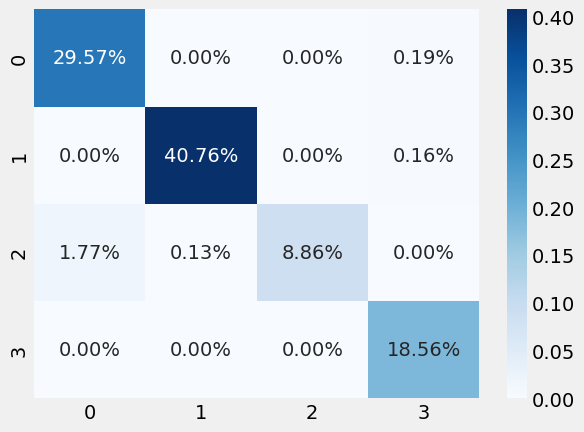

In [ ]:
# Percentages
sn.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')